### Use a SOM to construct feature likelihood

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import abc

In [3]:
class MapGeometry(abc.ABC):
    
    def __init__(self, size):
        self._size = size
        self._separations = None
    
    @property
    def size(self):
        """The flattened size of this map.
        """
        return self._size
    
    @property
    def separations(self):
        """The matrix of pairwise separations between map nodes.
        
        Uses lazy evaluation.  The matrix might be sparse.
        """
        if self._separations is None:
            self._separations = self._calculate_separations()
        return self._separations
    
    @abc.abstractmethod
    def _calculate_separations(self):
        raise NotImplementedError()
        
    @abc.abstractmethod
    def plot(self, values, ax=None, **kwargs):
        """Plot a representation of the specified values for this map.
        
        Parameters
        ----------
        values : array
            1D array of length :attr:`size`    
        ax : matplotlib axis or None
            Plot axis to use, or create a default axis when None.
        kwargs : dict
            Additional plot keyword arguments to pass to the implementation.
        """
        raise NotImplementedError()

In [4]:
class Grid(MapGeometry):
    
    def __init__(self, *signature, metric='L2'):
        """Create a rectilinear grid map geometry.
        
        The grid shape is specified by the absolute values of the signature.        
        A negative value in the signature indicates that distances along the
        corresponding axis are calculated using wrap around.
        """
        shape = [abs(k) for k in signature]
        x = np.empty(shape=shape)
        super(Grid, self).__init__(x.size)
        self._shape = x.shape
        self._wrap = [k < 0 for k in signature]
        if metric not in ('L0', 'L1', 'L2'):
            raise ValueError('Invalid metric "{metric}", should be one of L0, L1, L2.')
        self._metric = metric
        
    @property
    def shape(self):
        return self._shape
    
    @property
    def wrap(self):
        return self._wrap
    
    @property
    def metric(self):
        return self._metric
    
    def _calculate_separations(self):
        ndim = len(self.shape)
        separation = np.zeros(self.shape + self.shape)
        # Loop over axes.
        for k, wrapk in enumerate(self._wrap):
            nk = self.shape[k]
            xk = np.arange(nk)
            # Calculate the the (nk, nk) matrix of absolute integer separations along the k-th axis.
            dxk = np.abs(xk.reshape(nk, 1) - xk)
            if wrapk:
                W = dxk > nk // 2
                dxk[W] *= -1
                dxk[W] += nk
            # Add this axis' contribution to the separation matrix.
            S = [(nk if (j % ndim == k) else 1) for j in range(2 * ndim)]
            dxk = dxk.reshape(S)
            if self._metric == 'L2':
                separation += dxk ** 2
            elif self._metric == 'L1':
                separation += dxk
            elif self._metric == 'L0':
                separation = np.maximum(separation, dxk)
        if self._metric == 'L2':
            # Take sqrt in place.
            np.sqrt(separation, out=separation)
        return separation.reshape(self.size, self.size)
    
    def plot(self, values, ax=None, **kwargs):
        """Plot an image of the input values.
        
        If the grid dimension is > 2, show a slice in the largest
        2 dimensions.
        """
        ndim = len(self.shape)
        if ndim == 1:
            # Plot a single row of values.
            values = values.reshape(1, self.size)
        elif ndim > 2:
            # Plot a slice in the largest 2 dimensions.
            largest = np.argsort(self.shape)[-2:]
            idx = [slice(None) if k in largest else 1 for k in range(ndim)]
            values = values[idx]
        ax = ax or plt.gca()
        ny, nx = values.shape
        ax.imshow(values, interpolation='none', origin='lower',
                  extent=[-0.5, nx - 0.5, -0.5, ny - 0.5], **kwargs)
        ax.axis('off')

In [5]:
class SelfOrganizingMap(object):
    
    def __init__(self, mapgeom):
        self._mapgeom = mapgeom
        
    def fit(self, data, maxiter=100, eta=0.5, init='random', seed=123):
        data = np.asarray(data)
        N, D = data.shape
        self._winner = np.empty(N, np.uint32)
        rng = np.random.RandomState(seed)
        if init == 'random':
            sigmas = np.std(data, axis=0)
            self._weights = sigmas.reshape(-1, 1) * rng.normal(size=(D, self._mapgeom.size))
        else:
            raise ValueError('Invalid init "{}".'.format(init))
        # Calculate mean separation between grid points as a representative large scale.
        large_scale = np.mean(self._mapgeom.separations)
        # Calculate the mean separation between N uniformly distributed points in D dimensions
        # as a representative small scale.
        volume = np.prod(self._mapgeom.shape)
        small_scale = (volume / N) ** (1 / D)
        assert small_scale < large_scale, 'Check the scales!'
        scale = large_scale
        dscale = (small_scale / large_scale) ** (1 / maxiter)
        for i in range(maxiter):
            loss = 0.
            for j, x in enumerate(data):
                # Calculate the Euclidean data-space distance squared between x and
                # each map site's weight vector.
                dx = x.reshape(-1, 1) - self._weights
                distsq = np.sum(dx ** 2, axis=0)
                # Find the map site with the smallest distance (largest dot product).
                self._winner[j] = k = np.argmin(distsq)
                # The loss is the sum of smallest (data space) distances for each data point.
                loss += np.sqrt(distsq[k])
                # Update all weights (dz are map-space distances).
                dz = self._mapgeom.separations[k]
                self._weights += eta * np.exp(-0.5 * (dz / scale) ** 2) * dx
            yield i, loss
            # Lower the scale for the next iteration.
            scale *= dscale

In [6]:
from astropy.table import Table
import time

In [7]:
def u_matrix(som):
    
    '''Add option to interpolate onto finer grid
    
    From p. 337 of this paper https://link.springer.com/content/pdf/10.1007%2F978-3-642-15381-5.pdf'''
    
    rows, cols, D = som.shape
    
    u_matrix = np.empty((rows, cols))
    
    for i in range(rows):
        for j in range(cols):
            dist = 0
            ## neighbor above
            if i < rows - 1:
                dist += np.sqrt(np.sum((som[i,j] - som[i+1,j]) ** 2))
            ## neighbor below
            if i > 0:
                dist += np.sqrt(np.sum((som[i,j] - som[i-1,j]) ** 2))
            ## neighbor left
            if j > 0:
                dist += np.sqrt(np.sum((som[i,j] - som[i,j-1]) ** 2))
            ## neighbor right
            if j < cols - 1:
                dist += np.sqrt(np.sum((som[i,j] - som[i,j+1]) ** 2))
            u_matrix[i,j] = np.sum(dist)

                
    ## interpolate u_matrix onto (2X-1) x (2Y-1) grid
    #x = np.arange(0,rows - interp_int, interp_int)
    #y = np.arange(0,cols - interp_int, interp_int)
            
    return(u_matrix)

In [8]:
def galaxy_demo(colors, nmap=-50, niter=100, eta=0.1):
    
    # Build the self-organizing map.
    som = SelfOrganizingMap(Grid(nmap, nmap))
    losses = []
    for it, loss in som.fit(colors, maxiter=niter, eta=eta):
        losses.append(loss)
        
    N, D = colors.shape

    # Plot the results.
    fig, ax = plt.subplots(2, 1, figsize=(8, 16))
    img = som._weights.T
    img = (img - img.min(axis=0)) / (img.max(axis=0) - img.min(axis=0))
    u_map = u_matrix(img.reshape(abs(nmap), abs(nmap), D))
    ax[0].imshow(u_map, interpolation='none', origin='lower', cmap='viridis')
    ax[0].axis('off')
    ax[1].plot(losses, 'ko')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Training Loss')
    plt.tight_layout()
    
    return(img.reshape(abs(nmap), abs(nmap), D))

gc_data_mag_cut = Table.read('../../../pz/cosmoDC2_small/cosmoDC2_mag_coord_cut.fits', format='ascii')
select_ra = np.logical_and(gc_data_mag_cut['ra'] >= 65.4, gc_data_mag_cut['ra'] < 65.8)
gc_ra_cut = gc_data_mag_cut[select_ra]
select_dec = np.logical_and(gc_ra_cut['dec'] >= -44.4, gc_ra_cut['dec'] < -44.)
gc_cut = gc_ra_cut[select_dec]

In [9]:
from GCR import GCRQuery
import GCRCatalogs    

In [10]:
gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In [9]:
# Select 4 deg x 4 deg patch

deg = 4
alpha = 0.78 # cos <DEC>
beta = (0.5 * deg) * (1/alpha - 1)

ra_min = 62.5 - beta
ra_max = 66.5 + beta
dec_min = -41.
dec_max = -37.
#dec_min = -46. * 0.8
#dec_max = -44. * 0.8

# Need to compensate for loss in area due to ra * cos(dec) correction (3D -> 2D)?
#ra_min /= np.cos(dec_max * np.pi / 180)
#ra_max /= np.cos(dec_max * np.pi / 180)

coord_filters = [
    'ra >= {}'.format(ra_min),
    'ra < {}'.format(ra_max),
    'dec >= {}'.format(dec_min),
    'dec < {}'.format(dec_max),
]

mag_filters = [
    'mag_r < 26.3',
    'mag_i < 26.3',
]

In [12]:
gc_data_mag_cut = gc.get_quantities(['ra', 'dec', 'redshift','mag_i', 'mag_g','mag_r', 'mag_u', 'mag_y', 'mag_z'], filters=(coord_filters + mag_filters))

In [13]:
u_g = gc_data_mag_cut['mag_u'] - gc_data_mag_cut['mag_g']
g_r = gc_data_mag_cut['mag_g'] - gc_data_mag_cut['mag_r']
r_i = gc_data_mag_cut['mag_r'] - gc_data_mag_cut['mag_i']
i_z = gc_data_mag_cut['mag_i'] - gc_data_mag_cut['mag_z']
z_y = gc_data_mag_cut['mag_z'] - gc_data_mag_cut['mag_y']
redshift = gc_data_mag_cut['redshift']
colors = np.asarray([u_g, g_r, r_i, i_z, z_y, redshift]).T

#### Visualize the data as a pairplot

In [14]:
import seaborn as sns
import pandas as pd

In [15]:
df = pd.DataFrame(colors, columns=('u-g', 'g-r', 'r-i', 'i-z', 'z-y', 'redshift'))

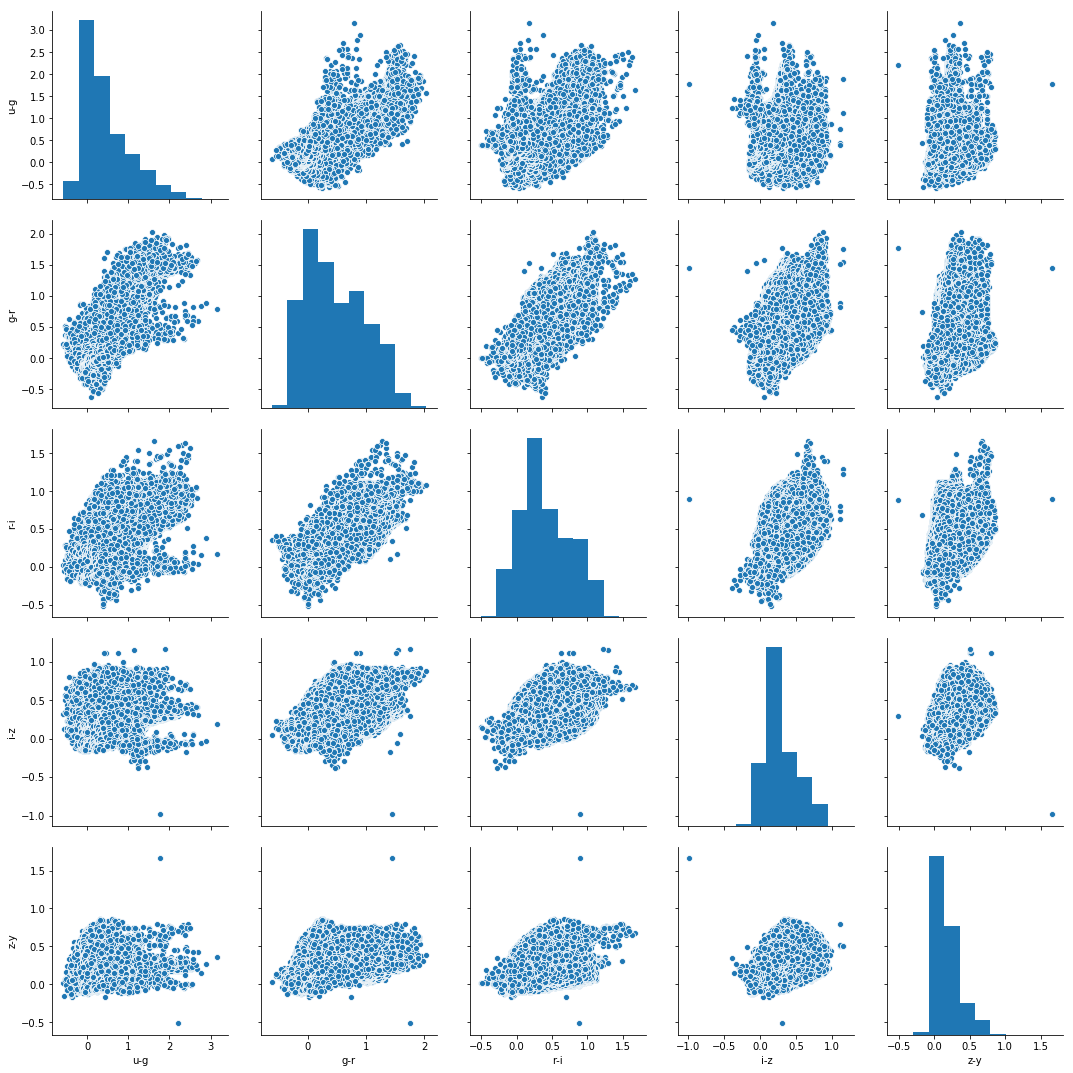

In [52]:
sns.pairplot(df.loc[:,'u-g':'z-y'][::200], height=3, aspect=1)

Run SOM on toy problem: generate random points on 2D grid and see that the SOM generated from this data is similar to the orignal data (basically does it collapse to a single cell or not)

In [22]:
rng = np.random.RandomState(seed=14)
rndm_2d = rng.uniform(size=(5000,2))

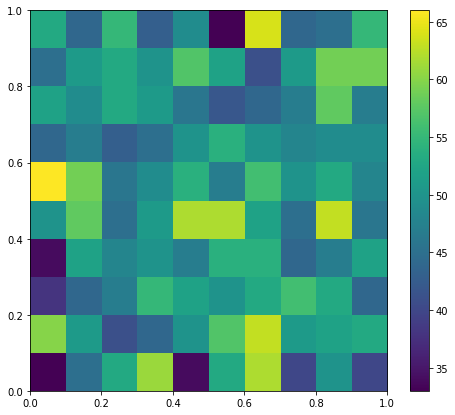

In [23]:
plt.figure(figsize=(8,7))
plt.hist2d(rndm_2d[:,0], rndm_2d[:,1], bins=10)
plt.colorbar()
plt.show()

### Understand 10x10 resolution SOM grid

13.910095930099487


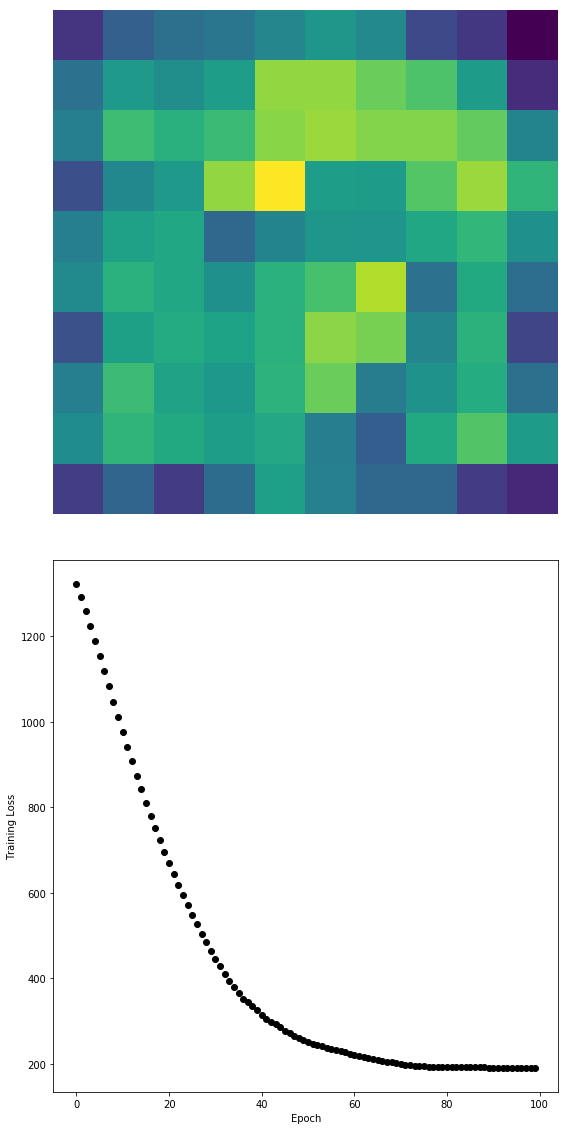

In [26]:
res = -10
start = time.time()
rndm_10 = galaxy_demo(rndm_2d, nmap=res)
print(time.time() - start)

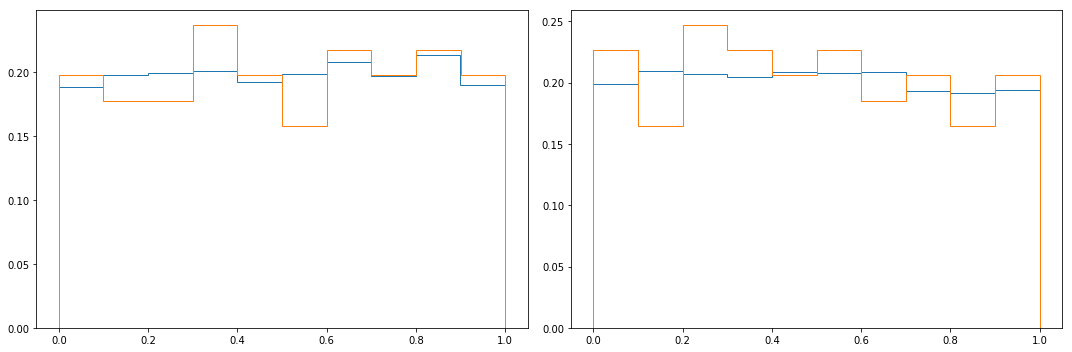

In [39]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs = axs.ravel()

axs[0].hist(rndm_2d[:,0], weights=np.ones(len(rndm_2d)) / np.sum(rndm_2d[:,0]), histtype='step')
axs[0].hist(rndm_10.reshape(100,2)[:,0], weights=np.ones(100) / np.sum(rndm_10.reshape(100,2)[:,0]), histtype='step')

axs[1].hist(rndm_2d[:,1], weights=np.ones(len(rndm_2d)) / np.sum(rndm_2d[:,1]), histtype='step')
axs[1].hist(rndm_10.reshape(100,2)[:,1], weights=np.ones(100) / np.sum(rndm_10.reshape(100,2)[:,1]), histtype='step')

plt.tight_layout()
plt.show()

In [74]:
som_indices = np.empty(len(rndm_2d), dtype=int)
for i, dat in enumerate(rndm_2d):
    dx = (dat - rndm_10.reshape(100,-1))
    dist = np.sqrt(np.sum(dx ** 2, axis=1))
    som_indices[i] = np.argmin(dist)

In [77]:
np.min(som_indices), np.max(som_indices)

(0, 99)

In [80]:
np.bincount(som_indices, minlength=100)

array([34, 54, 51, 28, 66, 43, 50, 61, 40, 45, 49, 70, 29, 61, 58, 58, 37,
       35, 31, 71, 49, 47, 57, 33, 41, 43, 56, 57, 26, 45, 57, 47, 52, 47,
       64, 53, 58, 63, 50, 43, 38, 41, 54, 44, 55, 41, 34, 38, 29, 40, 44,
       60, 63, 41, 33, 20, 49, 51, 22, 64, 49, 48, 48, 20, 56, 63, 75, 65,
       70, 61, 53, 47, 71, 53, 46, 55, 49, 51, 47, 40, 58, 58, 58, 47, 62,
       55, 49, 55, 67, 50, 60, 66, 66, 39, 42, 41, 43, 69, 73, 55])

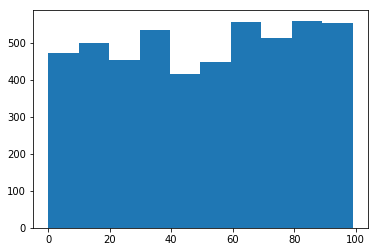

In [85]:
plt.hist(som_indices, bins=10)
plt.show()

- Why is training loss getting better then worse? Is it because zero is cut-off? No - looks like ~1800 is actually the smallest value...
- Is it getting worse then better because we are using too many iterations? Try with fewer (50) iterations
- I thought loss was the cumuluative sum of smallest distance between input vector and weight vector - so why is it increasing? It's because each loss value is the cumulative loss for all input vectors for a particular iteration

    som_cells = np.zeros(shape=(rows * cols)) ## vector of length data containing index in flattened som matrix to which each data vector belongs
    #som_cells2 = np.zeros(shape=(rows,cols))
    for i, j in enumerate(data):
        dx = j.reshape(-1,1) - som.reshape(-1,rows**2)
        distsq = np.sum(dx ** 2, axis=1)
        som_cells[np.argmin(distsq)] += 1
        #som_cells2[np.unravel_index(np.argmin(np.sum(np.abs(j.reshape(-1,1) - som.reshape(-1,100)), axis=0)), shape=(rows,cols))] += 1

In [20]:
def map_galaxies_to_som(data, som, statistic=np.mean):
    
    rows, cols, D = som.shape
    
    som_indices = np.empty(len(data), dtype=int)
    for i, dat in enumerate(data):
        dx = (dat - som.reshape(100,-1))
        dist = np.sqrt(np.sum(dx ** 2, axis=1))
        som_indices[i] = np.argmin(dist)
        
    counts = np.bincount(som_indices, minlength=(rows * cols))
        
    fig, axs = plt.subplots(1,2, figsize=(15,7))
    axs = axs.ravel()
        
    im0 = axs[0].imshow(counts.reshape(rows,cols), origin='lower', interpolation='none', cmap='viridis')
    fig.colorbar(im0, ax=axs[0])
    
    # redshift values are in last column of data matrix: data[:,-1]
    stat = np.asarray([statistic(data[:,-1][som_indices == i]) for i in range(rows * cols)])
    
    
    im1 = axs[1].imshow(stat.reshape(rows,cols), origin='lower', interpolation='none', cmap='viridis')
    fig.colorbar(im1, ax=axs[1])
    
    plt.tight_layout()
    plt.show()

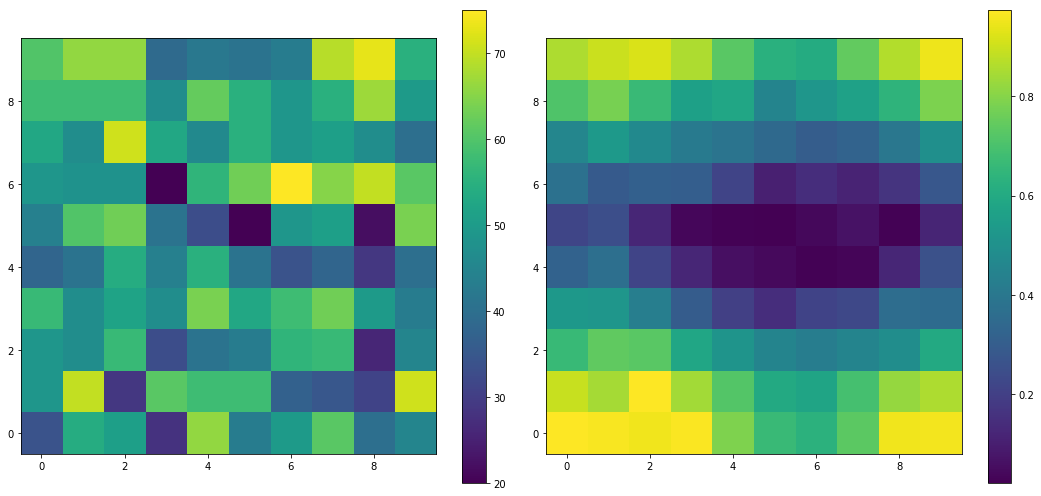

In [90]:
map_galaxies_to_som(rndm_2d, rndm_10, statistic=np.mean)

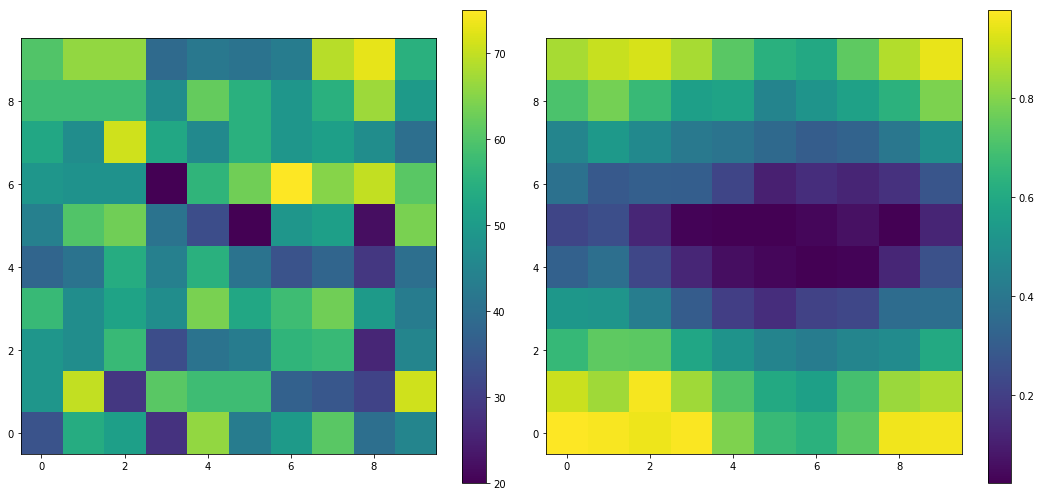

In [91]:
map_galaxies_to_som(rndm_2d, rndm_10, statistic=np.median)

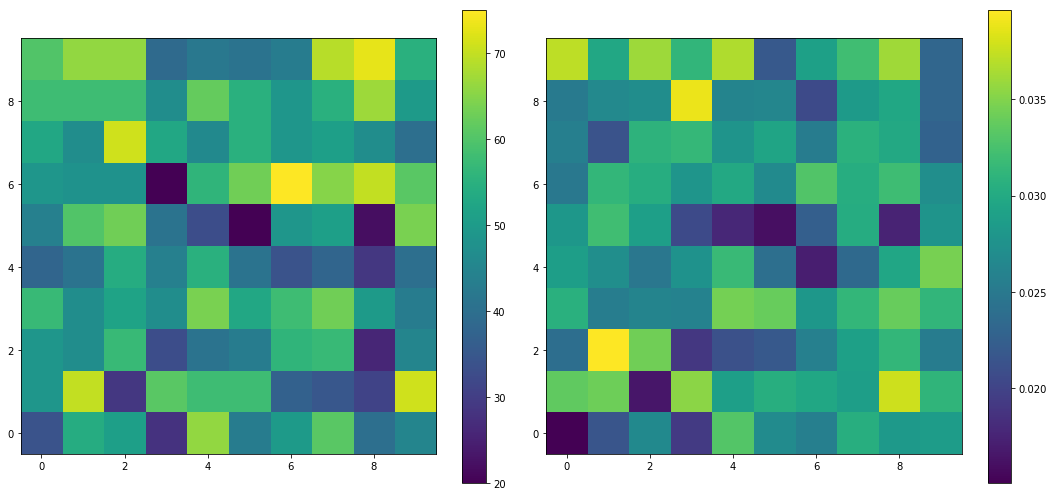

In [92]:
map_galaxies_to_som(rndm_2d, rndm_10, statistic=np.std)

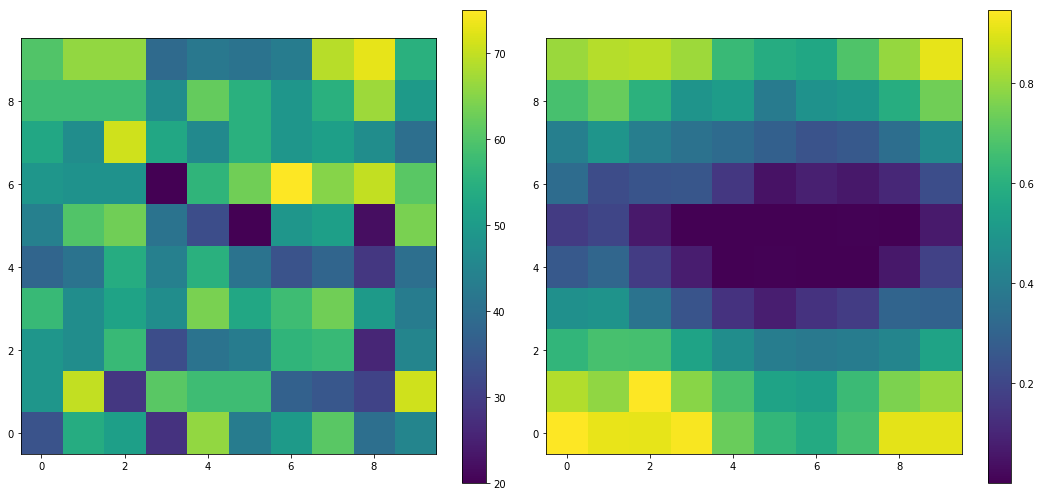

In [93]:
map_galaxies_to_som(rndm_2d, rndm_10, statistic=np.min)

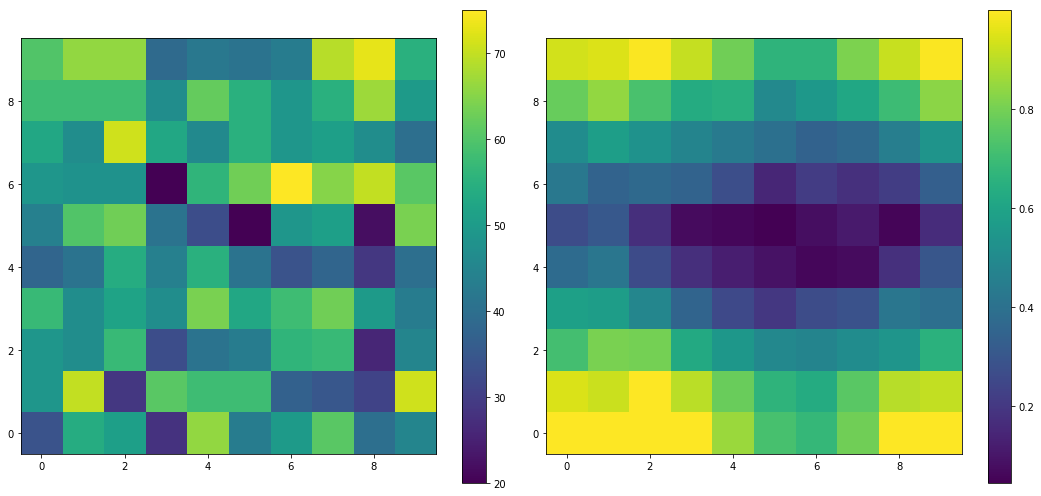

In [94]:
map_galaxies_to_som(rndm_2d, rndm_10, statistic=np.max)

In [ ]:
## make sns.corner plot of u-g, etc colors -- done
## increase colors in SOM -- done
## consider using more galaxies to make the som (then gradually decrease to see how it degrades the som)
## avg/med z in each cell
## min/max/std of z in each cell
## look at masters som paper to get a feel for what paramters to use for SOM

(3, 1024)
119.52241897583008


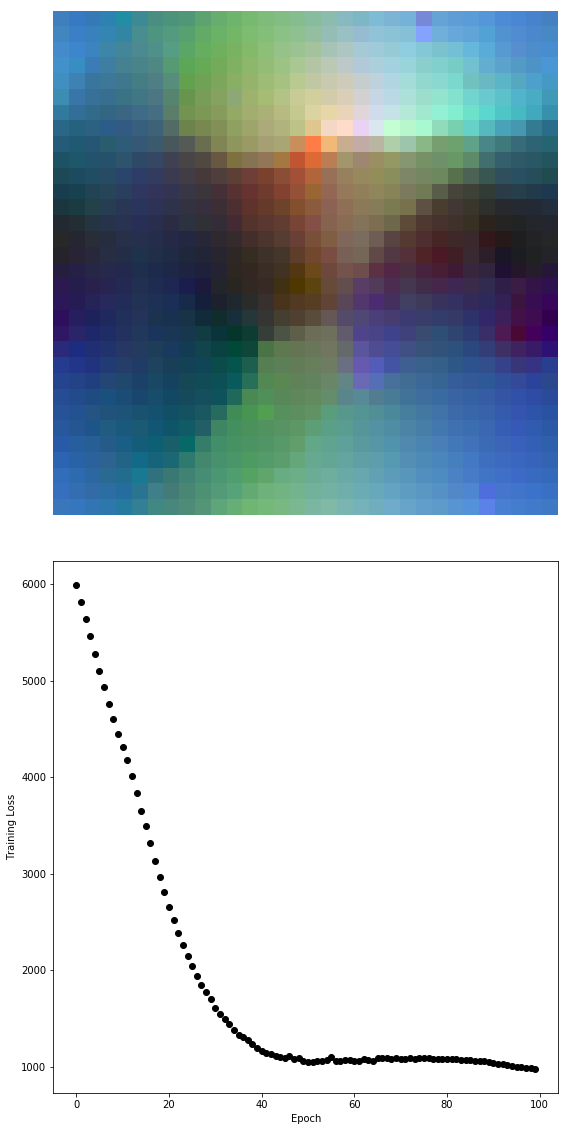

In [73]:
# resolution = 32
start = time.time()
galaxy_som32 = galaxy_demo(colors, nmap=-32)
print(time.time() - start)

Too much variation per cell...try increasing resolution to 50:

(3, 2500)
228.89204001426697


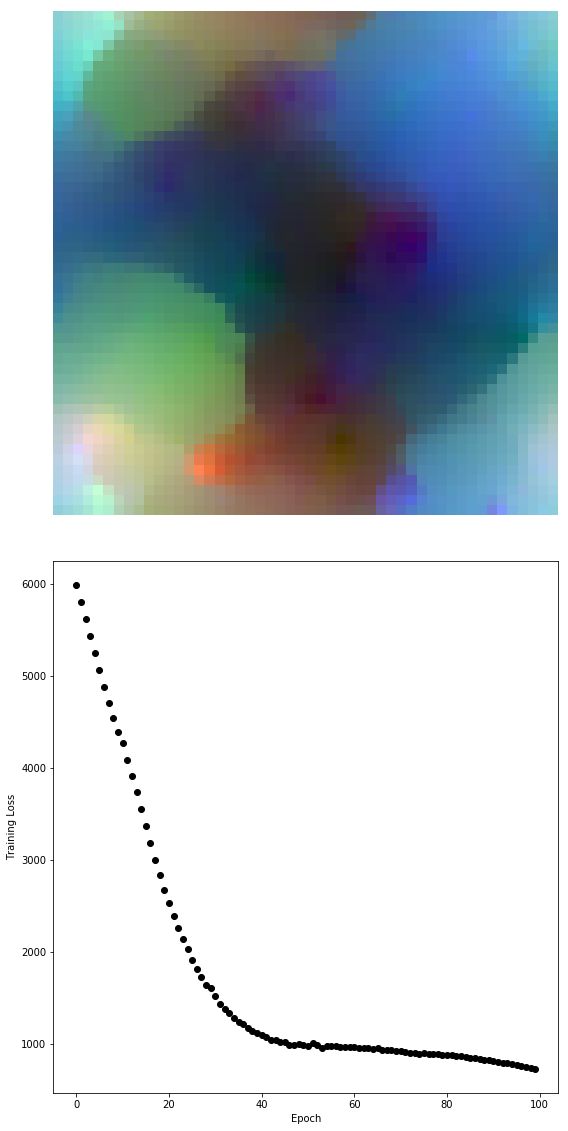

In [122]:
# resolution = 50
res = -50
start = time.time()
galaxy_som50 = galaxy_demo(colors, nmap=res)
print(time.time() - start)

436.99661898612976


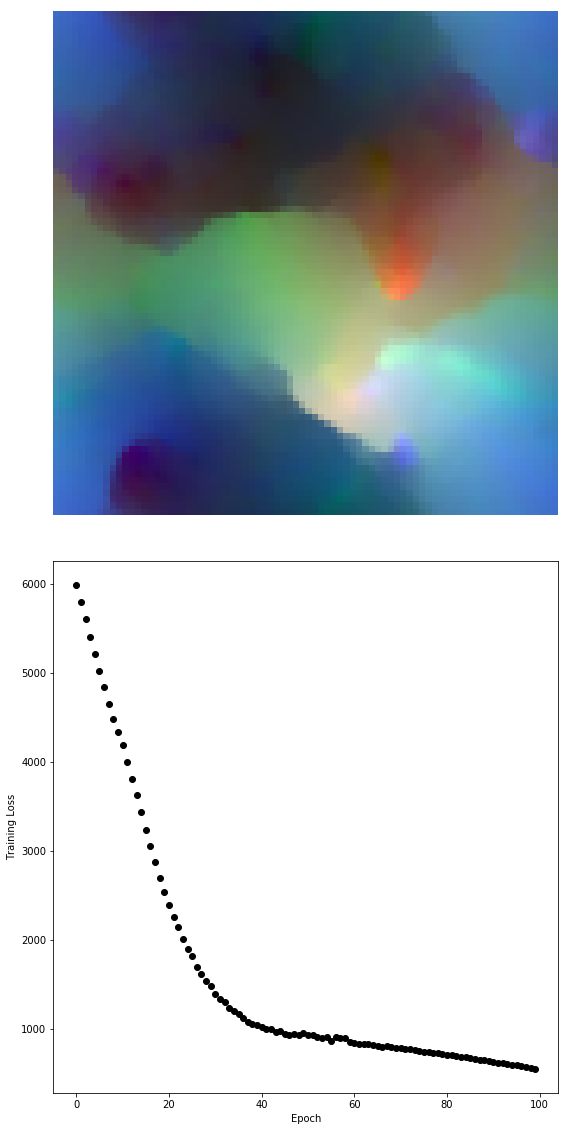

In [138]:
res = -80
start = time.time()
galaxy_som80 = galaxy_demo(colors, nmap=res)
print(time.time() - start)

In [141]:
# Generate random errors for each feature
sig1 = 0.006 # mean error in i-band
sig2 = 0.002 # mean error in r-band
errs = rng.multivariate_normal(mean=(sig1, sig2), cov=[[0.001 ** 2, 0], [0, 0.0005 ** 2]], size=len(rndm_2d))

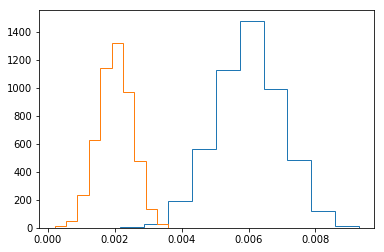

In [142]:
# Make sure errors aren't negative
plt.hist(errs[:,0], histtype='step')
plt.hist(errs[:,1], histtype='step')
plt.show()

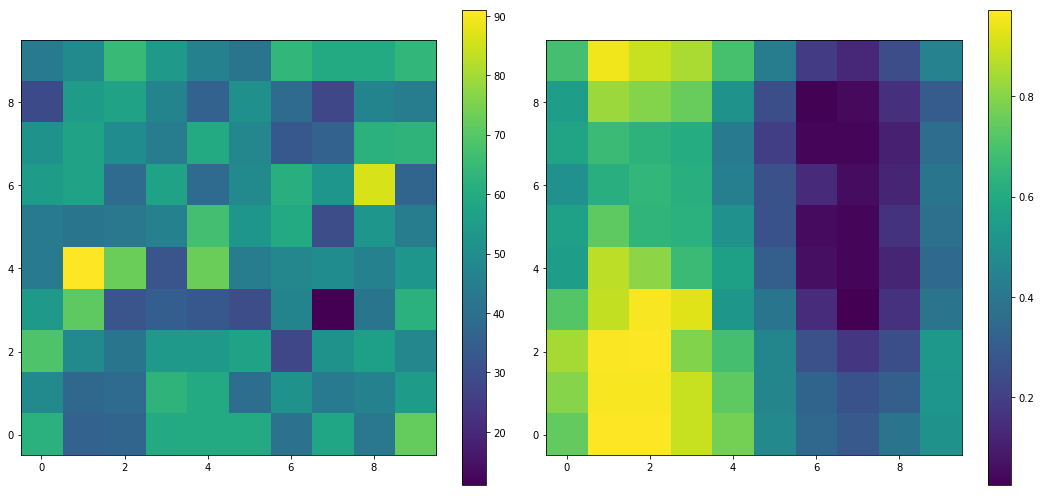

In [25]:
map_galaxies_to_som(rndm_2d, rndm_10, statistic=np.mean)

In [112]:
# Want to map random points to SOM cells while accounting for the errors in each feature
# Assume features independent of each other (i.e. diagonal covariance, not realistic)
# For a single data vector:
rng.multivariate_normal(mean=rndm_2d[0], cov=[[errs[0][0] ** 2, 0],[0, errs[0][1] ** 2]], size=1)

array([[0.51243666, 0.7736373 ]])

In [143]:
sampled = np.zeros_like(rndm_2d)
test = np.zeros(len(rndm_2d))
for i, dat in enumerate(rndm_2d):
    sampled[i] = rng.multivariate_normal(mean=dat, cov=[[errs[i][0] ** 2, 0],[0, errs[i][1] ** 2]], size=1)
    test[i] = rng.normal(loc=dat[1], scale=errs[i][1], size=1)

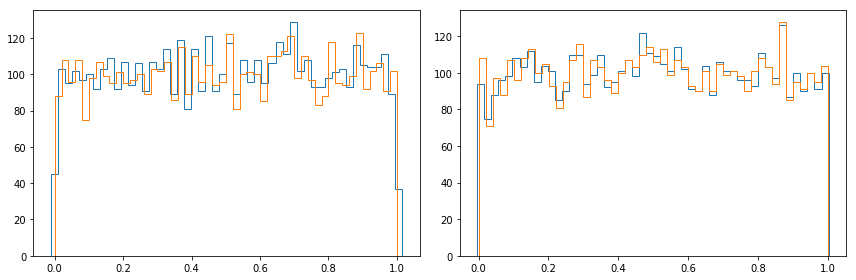

In [144]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
axs = axs.ravel()

axs[0].hist(sampled[:,0], bins=50, histtype='step')
axs[0].hist(rndm_2d[:,0], bins=50, histtype='step')

axs[1].hist(sampled[:,1], bins=50, histtype='step')
axs[1].hist(rndm_2d[:,1], bins=50, histtype='step')

plt.tight_layout()
plt.show()